# D2M1_3_redes_neuronales

## Caso de Estudio: Modelado de Población en Cartago (2018-2023)

El objetivo de este ejercicio  es modelar y predecir la densidad poblacional en el municipio de Cartago utilizando información espectral satelital y un modelo de redes neurales.

**Fuente de Datos**

 * Pobl_CNPV2018_76147_re.tif (Población 2018): Generada a partir de los datos censales del DANE (Departamento Administrativo Nacional de Estadística) de Colombia.

 * Sentinel2_MSI_Level2A_2018_76147_re.tif
 * Sentinel2_MSI_Level2A_2018_76147_re

| Banda | Variable en Código | Rango Espectral | Descripción y Relevancia |
|-------|-------------------|----------------|--------------------------|
| Banda 4 (Roja) | B4_2018 | Rojo | Fuerte absorción por la clorofila; importante para diferenciar la vegetación densa (baja reflectancia) de áreas con poca vegetación o superficies inertes (alta reflectancia). |
| Banda 3 (Verde) | B3_2018 | Verde | Usada en combinación con otras para medir la salud de la vegetación. |
| Banda 2 (Azul) | B2_2018 | Azul | Útil para la identificación de cuerpos de agua y penetración atmosférica, aunque menos crucial para análisis directos en áreas urbanas. |
| Banda 8 (Infrarrojo Cercano) | B8_2018 | NIR | Crítica para el mapeo urbano. Alta reflectancia en la vegetación sana y baja en cuerpos de agua. Ayuda a diferenciar materiales de construcción y suelos desnudos respecto a la vegetación. |


## Cargue librerias

In [1]:
%%capture
pip install rasterio

In [2]:
import re
import os
import zipfile
import geopandas as gpd
import pandas as pd
import rasterio as rs
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
from rasterio.features import rasterize
from pathlib import Path

In [3]:
os.chdir("/content")

## Lectura y exploración de datos

Se crea una carpeta llamada `1_insumos`, descarga dos archivos ZIP desde GitHub (uno vectorial y otro ráster), los descomprime dentro de esa carpeta y luego elimina los ZIP para ahorrar espacio.

In [4]:
%%capture


#Descargar el ZIP desde GitHub
!wget https://github.com/Luisafrodriguezo1/Diplomado_PDI/raw/refs/heads/main/D2M1_3_redes_neuronales/D2M1_3_RN_Recursos.zip -O /content/D2M1_3_RN_Recursos.zip

#Descomprimir
!unzip /content/D2M1_3_RN_Recursos.zip


In [5]:
# remover zip
!rm /content/*.zip

In [6]:
poblacion2018 = rs.open('/content/D2M1_3_RN_Recursos/Pobl_CNPV2018_76147_re.tif')
sentinel_2018 = rs.open('/content/D2M1_3_RN_Recursos/Sentinel2_MSI_Level2A_2018_76147_re.tif')
sentinel_2023 = rs.open('/content/D2M1_3_RN_Recursos/Sentinel2_MSI_Level2A_2023_76147_re.tif')

po_2018 = poblacion2018.read()[0]
B4_2018 = sentinel_2018.read()[0]
B3_2018 = sentinel_2018.read()[1]
B2_2018 = sentinel_2018.read()[2]
B8_2018 = sentinel_2018.read()[3]
B4_2023= sentinel_2018.read()[0]
B3_2023 = sentinel_2023.read()[1]
B2_2023 = sentinel_2023.read()[2]
B8_2023 = sentinel_2023.read()[3]

Verificar en qué coordenadas/proyección está cada dataset para saber si son compatibles entre sí

In [7]:
print( poblacion2018.crs )
print( sentinel_2018.crs )
print( sentinel_2023.crs )

EPSG:4326
EPSG:4326
EPSG:4326


In [8]:
capas_2018 = ['po_2018','B4_2018','B3_2018','B2_2018','B8_2018']
capas_2023 = ['B4_2023','B3_2023','B2_2023','B8_2023']

`globals()` devuelve un diccionario con todas las variables globales del programa.
Solo funciona si le pasas un texto  `string`con el nombre exacto de una variable, así puede buscarla y devolver su valor.

In [9]:
globals()['capas_2023']

['B4_2023', 'B3_2023', 'B2_2023', 'B8_2023']

Se visualizan las capas para revisar que se cargaron correctamente

po_2018


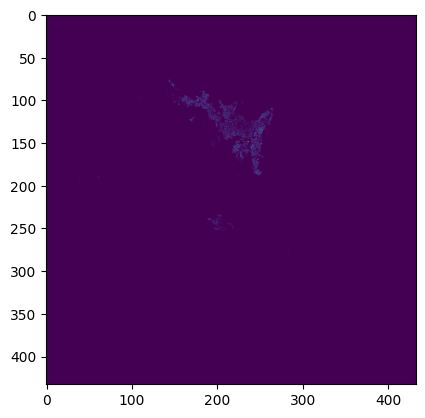

 
B4_2018


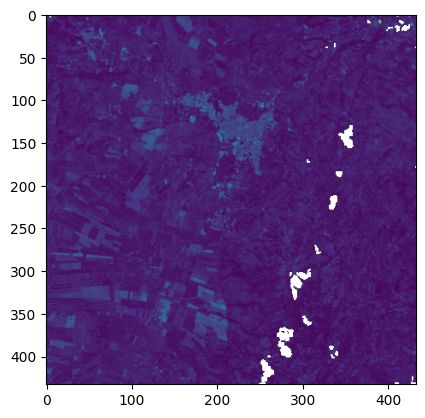

 
B3_2018


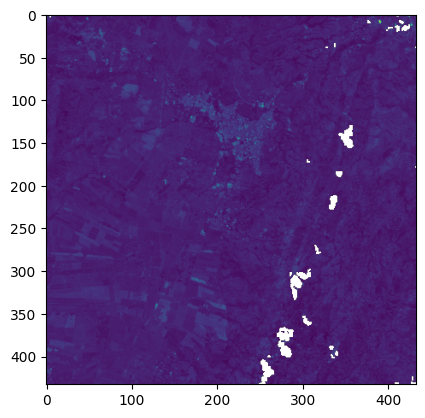

 
B2_2018


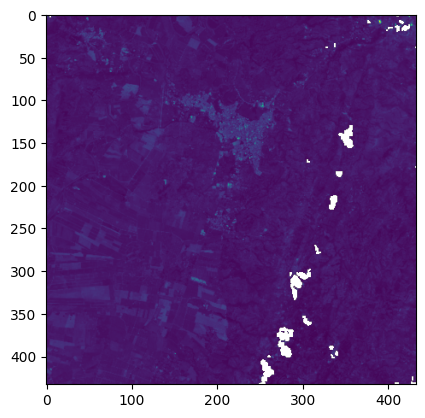

 
B8_2018


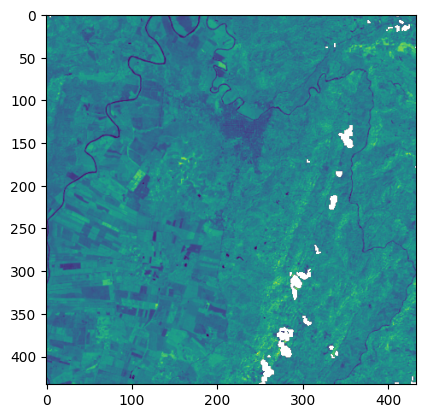

In [10]:
for nom in capas_2018:
  print( nom  )
  show(locals()[ nom ])
  print( ' ' )

Verificar que todas tengan las mismas dimensiones para poder analizarlas juntas.

In [11]:
for nom in capas_2018:
  print( nom + ':' )
  print( globals()[ nom ].shape )
  print( ' ' )

po_2018:
(433, 433)
 
B4_2018:
(433, 433)
 
B3_2018:
(433, 433)
 
B2_2018:
(433, 433)
 
B8_2018:
(433, 433)
 


Esta función cuenta los píxeles de la capa según su valor: cuántos hay en total, cuántos son cero, cuántos son diferentes de cero y cuántos son NaN.

In [12]:
def contar_pixeles(capa):
    total = capa.size
    ceros = np.sum(capa == 0)
    nans = np.sum(np.isnan(capa))
    no_ceros = np.sum((capa != 0) & (~np.isnan(capa)))


    print("Total pixeles:", total)
    print("Pixeles = 0:", ceros)
    print("Pixeles != 0:", no_ceros)
    print("Pixeles NaN:", nans)


In [13]:
contar_pixeles(po_2018)

Total pixeles: 187489
Pixeles = 0: 183304
Pixeles != 0: 4185
Pixeles NaN: 0


Mínimo: 1.0
Q1: 5.0
Mediana (Q2): 20.0
Q3: 43.0
Máximo: 547.0
Desviación estándar: 28.73574


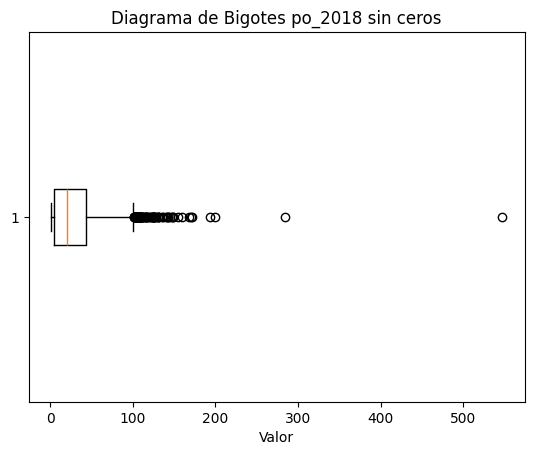

In [14]:
po_2018_sin_ceros = po_2018[po_2018 != 0]


# Estadísticos
print("Mínimo:", np.min(po_2018_sin_ceros))
print("Q1:", np.percentile(po_2018_sin_ceros, 25))
print("Mediana (Q2):", np.percentile(po_2018_sin_ceros, 50))
print("Q3:", np.percentile(po_2018_sin_ceros, 75))
print("Máximo:", np.max(po_2018_sin_ceros))
print("Desviación estándar:", np.std(po_2018_sin_ceros))

# Boxplot
plt.boxplot(po_2018_sin_ceros, vert=False)
plt.title("Diagrama de Bigotes po_2018 sin ceros")
plt.xlabel("Valor")
plt.show()


In [15]:
contar_pixeles(B3_2018)

Total pixeles: 187489
Pixeles = 0: 0
Pixeles != 0: 185633
Pixeles NaN: 1856


Ordena todos los valores de po_2018 y muestra los 10 valores más altos

In [16]:
top20 = np.sort(po_2018, axis=None)[-10:]
print(top20)

[149. 155. 160. 168. 170. 171. 193. 200. 284. 547.]


## Construcción conjunto de datos

In [36]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

 Aplanar cada matriz HxW a un vector (N_pixels,) para tratar cada píxel como una muestra

In [18]:

B_flats = [b.flatten() for b in [B4_2018, B3_2018, B2_2018, B8_2018]]
po_flat = po_2018.flatten()

Crear la matriz de Features (N_pixels, 4 bandas)

In [19]:

X_raw = np.column_stack(B_flats)
y_raw = po_flat.copy()
print(f"Dimensiones de X: {X_raw.shape}")
print(f"Dimensiones de y: {y_raw.shape}")

Dimensiones de X: (187489, 4)
Dimensiones de y: (187489,)


Filtrado de Píxeles Vacíos (NaNs)

In [20]:

nan_mask = np.isnan(X_raw).any(axis=1) | np.isnan(y_raw)
X_filtrado = X_raw[~nan_mask]
y_filtrado = y_raw[~nan_mask]
print(f"Píxeles Filtrados: {len(X_filtrado)}")

Píxeles Filtrados: 185633


Balanceo por Submuestreo Estratégico, identificando grupos de pixeles poblado (y >= 1) y No poblado (y = 0)

In [21]:

mask_poblado = (y_filtrado >= 1)
X_poblado, y_poblado = X_filtrado[mask_poblado], y_filtrado[mask_poblado]
X_no_poblado, y_no_poblado = X_filtrado[~mask_poblado], y_filtrado[~mask_poblado]

n_poblado = len(X_poblado)
n_no_poblado = len(X_no_poblado)

print(f"Poblado: {n_poblado}")
print(f"No Poblado: {n_no_poblado}")


Poblado: 4167
No Poblado: 181466


In [22]:
if n_no_poblado > n_poblado:
    indices_submuestreo = np.random.choice(n_no_poblado, size=n_poblado, replace=False)
    print(indices_submuestreo)
    X_submuestreado, y_submuestreado = X_no_poblado[indices_submuestreo], y_no_poblado[indices_submuestreo]


    X_balanceado = np.vstack((X_poblado, X_submuestreado))
    y_balanceado = np.concatenate((y_poblado, y_submuestreado))


print(f"Tamaño Final Balanceado: {len(X_balanceado)}")

[  7026  19183   5835 ... 154449  26328  88603]
Tamaño Final Balanceado: 8334


Dividir los datos balanceados en entrenamiento y prueba.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X_balanceado,
    y_balanceado,
    test_size=0.2,
    random_state=42,
    shuffle=True # primero baraja los datos
)
print(f"Tamaño Train: {len(X_train)}")
print(f"Tamaño Test: {len(X_test)}")
print(f"Tamaño Train: {len(y_train)}")
print(f"Tamaño Test: {len(y_test)}")

Tamaño Train: 6667
Tamaño Test: 1667
Tamaño Train: 6667
Tamaño Test: 1667


Normaliza los datos para que todas las variables estén entre 0 y 1, usando el rango aprendido del conjunto de entrenamiento, y aplica esa misma escala al entrenamiento y al test

In [24]:
scaler_X = MinMaxScaler()
scaler_X.fit(X_train)

X_train_scaled = scaler_X.transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
print(f"X_train Normalizado shape: {X_train_scaled.shape}")
print(f"X_test Normalizado shape: {X_test_scaled.shape}")


X_train Normalizado shape: (6667, 4)
X_test Normalizado shape: (1667, 4)


# Entrenamiento

Define un modelo MLP para regresión: recibe las características de entrada, pasa por tres capas densas con activaciones distintas y termina con una sola neurona en la salida para predecir el valor objetivo

| Activación   | Para qué sirve                                                       |
| ------------ | -------------------------------------------------------------------- |
| `relu`       | La más común en capas ocultas, rápida y evita problemas de gradiente |
| `leaky_relu` | Similar a ReLU, pero permite gradientes cuando es negativo           |
| `tanh`       | Centra valores entre -1 y 1, útil en datos normalizados              |
| `sigmoid`    | Para probabilidades, normalmente en salida de clasificación          |



In [25]:
def create_mlp_model(input_shape):

    inputs = layers.Input(shape=(input_shape,), name="Capa_Entrada")

    x = layers.Dense(128, activation="relu")(inputs)
    x = layers.Dense(64, activation="tanh")(x)
    x = layers.Dense(32, activation="sigmoid")(x)

    #  1 neurona, activación Lineal (None) para Regresión
    outputs = layers.Dense(1, activation=None, )(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="MLP_Regresion_Poblacion")
    return model

In [26]:
num_features = X_train_scaled.shape[1]
print(f'numero de bandas: {num_features}')

numero de bandas: 4


In [27]:
model = create_mlp_model(num_features)


Compila el modelo indicando el optimizador, la función de pérdida y la métrica para evaluar.

In [28]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='mse',
    metrics=['mae']
)

print(" Resumen de la Arquitectura del MLP")
model.summary()



 Resumen de la Arquitectura del MLP


Model: "MLP_Regresion_Poblacion"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Capa_Entrada (InputLayer)       │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,009 (43.00 KB)

 Trainable params: 11,009 (43.00 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=100,                  # Número de epochs
    batch_size=64,               # Tamaño del batch
    validation_split=0.10,       # Usar 10% de Train para validación interna
    verbose=1                    # Mostrar el progreso
)

Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 713.6953 - mae: 13.9092 - val_loss: 766.9188 - val_mae: 14.3496
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 758.9485 - mae: 14.4369 - val_loss: 749.7215 - val_mae: 14.3879
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 739.3137 - mae: 14.4551 - val_loss: 725.6011 - val_mae: 14.4953
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 684.4251 - mae: 14.1560 - val_loss: 706.6193 - val_mae: 14.6587
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 668.9849 - mae: 14.5023 - val_loss: 695.3746 - val_mae: 14.8008
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 649.8856 - mae: 14.1412 - val_loss: 688.0301 - val_mae: 14.8766
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 645.3060 - mae: 14.5220 - val_loss: 681.8627 - val_mae: 14.8393
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 687.6464 - mae: 14.8490 - val_loss: 675.1414 - val_mae: 14.5383
Epoch 9/100
94/9

In [30]:
def plot_training_history(history):
    """
    Genera gráficas para la Pérdida (Loss) y el Error Absoluto Medio (MAE)
    para los conjuntos de entrenamiento y validación a lo largo de las epochs.
    """
    # Extraer las métricas del objeto history
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_mae = history.history['mae']
    val_mae = history.history['val_mae']

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(10, 4))

    # Pérdida (Loss - MSE)
    plt.subplot(1, 2, 1) # 1 fila, 2 columnas, posición 1
    plt.plot(epochs, train_loss, 'bo-', label='Pérdida Entrenamiento (Loss Train)')
    plt.plot(epochs, val_loss, 'r^-', label='Pérdida Validación (Loss Validación)')
    plt.title('Pérdida (MSE) durante el Entrenamiento')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)

    # Error Absoluto Medio (MAE)
    plt.subplot(1, 2, 2) # 1 fila, 2 columnas, posición 2
    plt.plot(epochs, train_mae, 'bo-', label='MAE Entrenamiento (MAE Train)')
    plt.plot(epochs, val_mae, 'r^-', label='MAE Validación (MAE Validación)')
    plt.title('Error Absoluto Medio (MAE) durante el Entrenamiento')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)

    plt.tight_layout() # Ajusta automáticamente los subplots
    plt.show()



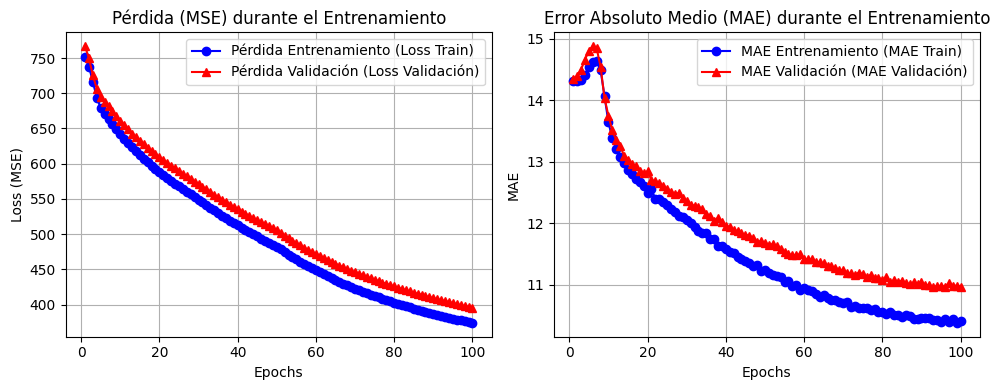

In [34]:

plot_training_history(history)

In [37]:
y_pred = model.predict(X_test_scaled)

# 2. Definir los valores verdaderos (del conjunto de prueba)
y_true = y_test
label = "Prueba (Test)"

# 3. Calcular las métricas
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# 4. Imprimir los resultados
print(f"\n--- Métricas en el conjunto {label} ---")
print(f"  MSE (Mean Squared Error): {mse:.4f}")
print(f"  RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"  MAE (Mean Absolute Error): {mae:.4f}")
print(f"  R-squared (R2 Score): {r2:.4f}")

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

--- Métricas en el conjunto Prueba (Test) ---
  MSE (Mean Squared Error): 484.7449
  RMSE (Root Mean Squared Error): 22.0169
  MAE (Mean Absolute Error): 10.4243
  R-squared (R2 Score): 0.3073


##

In [38]:
import numpy as np
import rasterio
from sklearn.preprocessing import MinMaxScaler
# Asumimos que model/mlp_regressor y scaler_X están definidos.

def guardar_raster_predicho(B4_2023, B3_2023, B2_2023, B8_2023, model, scaler_X, path_metadata_original, path_salida):
    """
    Prepara los datos, predice la población y guarda el resultado como un GeoTIFF
    con la georreferenciación de un archivo original.

    Args:
        B4_2023, B3_2023, B2_2023, B8_2023 (np.ndarray): Matrices 2D de las bandas Sentinel 2023.
        model (object): Modelo de regresión entrenado (Keras o Scikit-learn).
        scaler_X (MinMaxScaler): Objeto MinMaxScaler ajustado con datos de entrenamiento.
        path_metadata_original (str): Ruta al archivo Sentinel/Población original para extraer la metadata.
        path_salida (str): Ruta y nombre del archivo GeoTIFF de salida (ej. 'poblacion_predicha_2023.tif').

    Returns:
        bool: True si el guardado fue exitoso, False en caso contrario.
    """



    H, W = B4_2023.shape
    N_pixels = H * W
    print(f'Tamaño raster{B4_2023.shape}')


    B_flats = [b.flatten() for b in [B4_2023, B3_2023, B2_2023, B8_2023]]
    X_raw = np.column_stack(B_flats)

    # Máscara de NaNs y Filtrado
    nan_mask = np.isnan(X_raw).any(axis=1)
    X_pred_valid = X_raw[~nan_mask]

    # Normalización (Escalado)
    X_pred_scaled = scaler_X.transform(X_pred_valid)


    y_pred_valid = model.predict(X_pred_scaled).flatten()


    # Reconstrucción del Raster 2D
    prediction_raster_1d = np.full((N_pixels,), np.nan, dtype=np.float32)
    prediction_raster_1d[~nan_mask] = y_pred_valid
    prediction_raster_2d = prediction_raster_1d.reshape((H, W))

    print(f"Predicción lista. Shape: {prediction_raster_2d.shape}")


    #  Obtención de Metadata

    try:
        # Abrir el archivo original para obtener la metadata (coordenadas, CRS, etc.)
        with rasterio.open(path_metadata_original) as src:
            profile = src.profile
            # Obtener el valor de NoData de la fuente (si existe)
            nodata_value = src.nodata

        #
        profile.update(
            dtype=rasterio.float32,  # Usar float para los valores continuos de población
            count=1,                 # El raster solo tiene 1 banda (la predicción)
            nodata=nodata_value      # Usar el NoData de la fuente
        )

        # 2.3 Escribir el nuevo archivo GeoTIFF
        with rasterio.open(path_salida, 'w', **profile) as dst:
            # Escribir la matriz de predicción en la primera (y única) banda
            dst.write(prediction_raster_2d, 1)

        print(f"\ Raster de predicción GeoTIFF guardado exitosamente en: {path_salida}")
        return True

    except rasterio.RasterioIOError:
        print(f"\n ERROR: No se pudo abrir o leer el archivo original en: {path_metadata_original}")
        print("Asegúrate de que la ruta al archivo de metadata original es correcta.")
        return False
    except Exception as e:
        print(f"\n ERROR inesperado durante el guardado: {e}")
        return False



<>:72: SyntaxWarning: invalid escape sequence '\ '
<>:72: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-474262903.py:72: SyntaxWarning: invalid escape sequence '\ '
  print(f"\ Raster de predicción GeoTIFF guardado exitosamente en: {path_salida}")


In [44]:
path_metadata_original = "/content/D2M1_3_RN_Recursos/Sentinel2_MSI_Level2A_2023_76147_re.tif"
path_salida= "/content/prediccion2023.tif"


guardado_exitoso = guardar_raster_predicho(
    # Matrices de entrada 2023 (sin aplanar)
    B4_2023,
    B3_2023,
    B2_2023,
    B8_2023,
    # Objetos entrenados
    model,
    scaler_X,
    # Rutas de archivo
    path_metadata_original,
    path_salida
)

Tamaño raster(433, 433)
5799/5799 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
Predicción lista. Shape: (433, 433)
\ Raster de predicción GeoTIFF guardado exitosamente en: /content/prediccion2023.tif


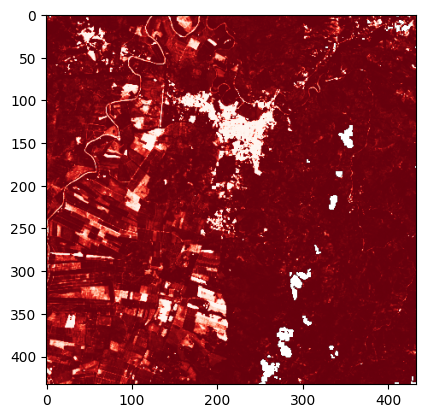

In [78]:
with rasterio.open(path_salida ) as src:
    pred_2023_matrix= src.read(1)
    show(pred_2023_matrix , cmap='Reds_r')

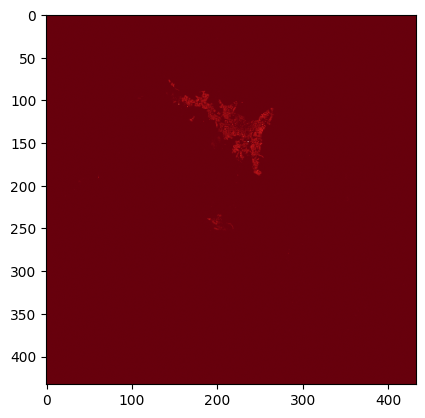

In [77]:

with rasterio.open('/content/D2M1_3_RN_Recursos/Pobl_CNPV2018_76147_re.tif' ) as src:
    pobl_2018_matrix= src.read(1)
    show(pobl_2018_matrix, cmap='Reds_r')

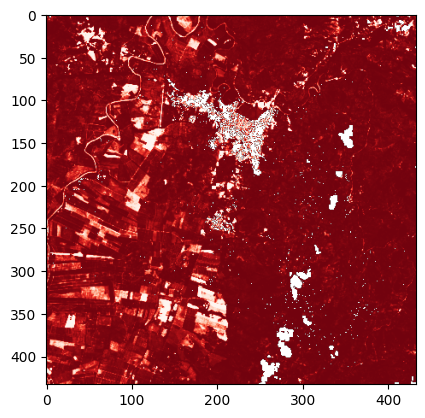

<Axes: >

In [82]:
cambio_matrix =  pred_2023_matrix- pobl_2018_matrix

visual_matrix = cambio_matrix.copy()

visual_matrix[visual_matrix < 0] = np.nan


show(visual_matrix  , cmap='Reds_r')
